In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\Rhushikesh\Downloads\counterfeit_products_renamed (1).csv')
print("Loaded:", df.shape)

Loaded: (5000, 27)


In [3]:
# drop duplicates early
duplicate_count = df.duplicated().sum()
if duplicate_count:
    df = df.drop_duplicates()
    print(f"Dropped {duplicate_count} duplicate rows. New shape: {df.shape}")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_ref           5000 non-null   object 
 1   vendor_code        5000 non-null   object 
 2   product_type       5000 non-null   object 
 3   manufacturer       5000 non-null   object 
 4   cost_usd           3652 non-null   float64
 5   vendor_score       5000 non-null   float64
 6   feedback_count     5000 non-null   int64  
 7   image_qty          5000 non-null   int64  
 8   desc_chars         5000 non-null   int64  
 9   delivery_period    5000 non-null   int64  
 10  typo_count         5000 non-null   int64  
 11  site_age           5000 non-null   float64
 12  contact_valid      5000 non-null   bool   
 13  return_clarity     5000 non-null   bool   
 14  payment_options    5000 non-null   int64  
 15  post_timestamp     5000 non-null   object 
 16  vendor_nation      5000 

In [4]:
# Define reusable functions and column selectors
def get_column_types(dataframe):
    return {
        'object_cols': dataframe.select_dtypes(include='object').columns,
        'numerical_cols': dataframe.select_dtypes(include=['number']).columns
    }

def create_subplot_grid(n_items, max_cols=4):
    n_cols = min(max_cols, n_items)
    n_rows = (n_items + n_cols - 1) // n_cols
    return n_rows, n_cols

def plot_categorical_distributions(dataframe, cols, title_suffix="", figsize_multiplier=3):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * figsize_multiplier))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    colors = sns.color_palette("Set2", len(cols))

    for i, col in enumerate(cols):
        counts = dataframe[col].value_counts(dropna=False)
        counts.plot(kind='bar', ax=axes[i], color=colors[i], alpha=0.8)
        axes[i].set_title(f'{col.title()}{title_suffix}', fontsize=12, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45, labelsize=9)

        # Add count labels on bars
        for j, v in enumerate(counts.values):
            axes[i].text(j, v + max(counts.values) * 0.01, str(v),
                        ha='center', va='bottom', fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def plot_numerical_distributions(dataframe, cols, title_suffix="", show_missing=True):
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("plasma", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create histogram
        dataframe[col].hist(bins=20, ax=ax, alpha=0.7, color=colors[i],
                           edgecolor='black', linewidth=0.5)

        # Add statistics
        col_mean = dataframe[col].mean()
        col_median = dataframe[col].median()
        col_missing = dataframe[col].isnull().sum()

        ax.axvline(col_mean, color='red', linestyle='--', alpha=0.8,
                  label=f'Mean: {col_mean:.1f}')
        ax.axvline(col_median, color='blue', linestyle='--', alpha=0.8,
                  label=f'Median: {col_median:.1f}')

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')

        # Add missing count annotation if requested
        if show_missing and col_missing > 0:
            ax.text(0.02, 0.98, f'Missing: {col_missing}', transform=ax.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                    fontsize=8)
        elif not show_missing:
            ax.text(0.02, 0.98, f'Complete: {len(dataframe) - col_missing}/{len(dataframe)}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                    fontsize=8)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def plot_boxplots_for_outliers(dataframe, cols, title_suffix=""):
    """Reusable function for boxplot visualization to detect outliers"""
    n_rows, n_cols = create_subplot_grid(len(cols), 4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()

    colors = sns.color_palette("coolwarm", len(cols))

    for i, col in enumerate(cols):
        ax = axes[i]

        # Create styled boxplot
        bp = ax.boxplot(dataframe[col].dropna(), patch_artist=True,
                       boxprops=dict(facecolor=colors[i], alpha=0.7),
                       medianprops=dict(color='black', linewidth=2),
                       flierprops=dict(marker='o', markerfacecolor='red', alpha=0.6, markersize=4))

        # Calculate outlier statistics
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)).sum()

        # Add outlier count annotation
        ax.text(0.02, 0.98, f'Outliers: {outliers_count}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=9)

        ax.set_title(f'{col}{title_suffix}', fontsize=11, pad=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Remove extra subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    return fig, axes

def cap_outliers_iqr(dataframe, columns, multiplier=1.5):
    """
    Winsorize (clip) outliers using the IQR method.

    Parameters:
    - dataframe: Input DataFrame
    - columns: List/Index of numeric columns to process
    - multiplier: IQR multiplier for outlier bounds (default 1.5)

    For each column:
    1. Compute Q1, Q3, IQR
    2. Compute lower = Q1 - multiplier*IQR; upper = Q3 + multiplier*IQR
    3. Count outliers before
    4. Clip values to [lower, upper]
    5. Count remaining outliers (should be zero or near-zero due to numeric precision)
    """
    df_capped = dataframe.copy()
    outlier_stats = {}

    for col in columns:
        if col in df_capped.columns:
            Q1 = df_capped[col].quantile(0.25)
            Q3 = df_capped[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            outliers_before = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            df_capped[col] = df_capped[col].clip(lower_bound, upper_bound)

            outliers_after = ((df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)).sum()

            outlier_stats[col] = {
                'outliers_before': int(outliers_before),
                'outliers_after': int(outliers_after),
                'lower_bound': float(lower_bound),
                'upper_bound': float(upper_bound),
                'Q1': float(Q1),
                'Q3': float(Q3),
                'IQR': float(IQR)
            }

    return df_capped, outlier_stats


In [5]:
# Define column types once - this will be updated as data changes
column_info = get_column_types(df)
print(f"Dataset loaded with {len(column_info['object_cols'])} categorical and {len(column_info['numerical_cols'])} numerical columns")

df.describe()

Dataset loaded with 8 categorical and 14 numerical columns


,cost_usd,vendor_score,feedback_count,image_qty,desc_chars,delivery_period,typo_count,site_age,payment_options,page_hits,sales_vol,saved_items,trust_seals,guarantee_term
count,3652.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,224.710643,3.732980,3529.809200,4.686200,463.56400,13.4622,1.093400,1467.886499,3.254000,2469.286600,123.050800,39.169600,2.026400,11.562000
std,136.900310,0.995313,3281.418979,2.651629,294.29469,11.5496,1.160752,1174.386070,1.357296,1424.525316,107.889725,28.945971,1.405453,6.882037
min,10.120000,1.000000,0.000000,1.000000,50.00000,1.0000,0.000000,1.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,109.825000,3.500000,85.000000,2.000000,179.00000,5.0000,0.000000,308.000000,2.000000,1245.750000,34.000000,13.000000,1.000000,6.000000
50%,191.815000,4.000000,2922.500000,5.000000,433.50000,10.0000,1.000000,1320.500000,3.000000,2433.000000,93.000000,34.000000,2.000000,12.000000
75%,336.615000,4.500000,6401.500000,7.000000,725.25000,18.0000,1.000000,2471.000000,4.000000,3701.500000,185.000000,62.000000,3.000000,18.000000
max,499.840000,5.000000,9996.000000,9.000000,999.00000,44.0000,4.000000,9995.291780,5.000000,4996.000000,491.000000,99.000000,4.000000,23.000000


Total missing values: 3344
Percentage missing: 2.48%


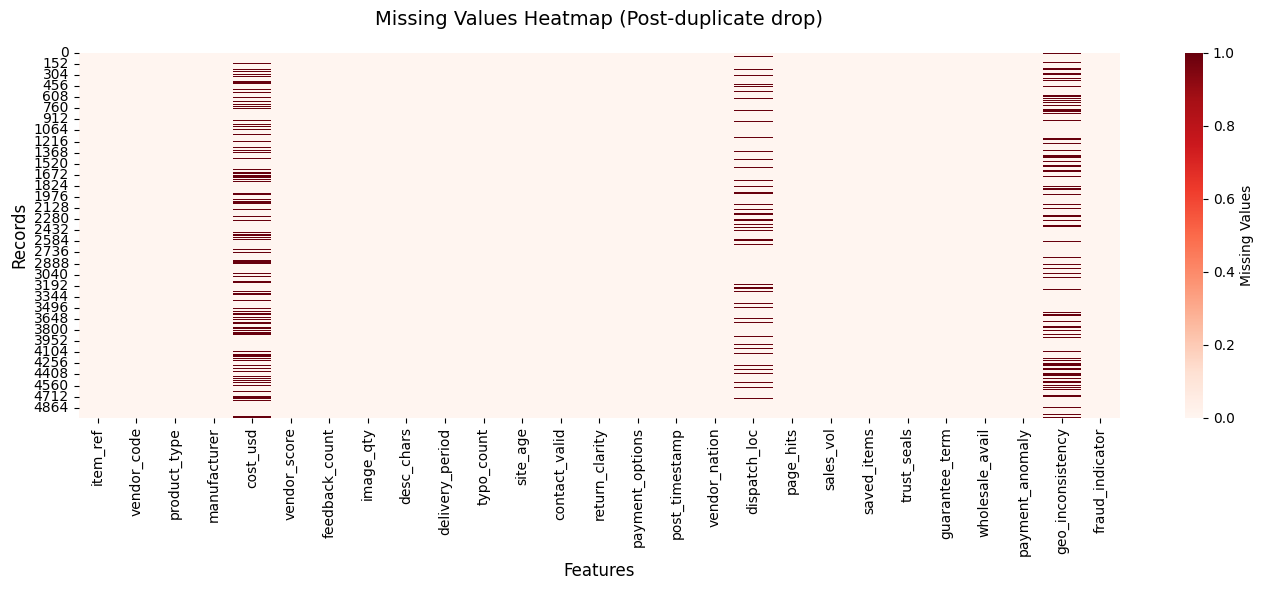

In [6]:
# calculate missing values statistics once
missing_stats = {
    'missing_values': df.isnull().sum(),
    'total_missing': df.isnull().sum().sum(),
    'total_cells': df.shape[0] * df.shape[1]
}

print(f"Total missing values: {missing_stats['total_missing']}")
print(f"Percentage missing: {(missing_stats['total_missing'] / missing_stats['total_cells']) * 100:.2f}%")

# clean, focused heatmap
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='Reds',
           cbar_kws={'label': 'Missing Values'}, ax=ax)
ax.set_title('Missing Values Heatmap (Post-duplicate drop)', fontsize=14, pad=20)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Records', fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
 # analyze categorical columns (using predefined column_info)
print("Categorical column unique values:")
for col in column_info['object_cols']:
    unique_vals = df[col].value_counts(dropna=False).index.tolist()
    print(f"{col}: {unique_vals}")
    print()

Categorical column unique values:
item_ref: ['dcb12716', 'd1f8b777', '9989f13a', '4e008120', '933b65ba', '52a410fa', '59e1a27b', 'b8fa970d', '3c4f5456', 'f4068089', '96c8f664', 'c579133d', 'a1eb801e', 'efbff36f', '7173d73b', '5a9e4cb9', '3b6e8f9e', '5d54170e', 'de7633dc', 'db4a206f', '8dcc387a', 'd3834818', 'a9e3a9ee', 'cf522349', '9f97f638', 'c44a7842', '4f0d1a73', '6701c705', '2499d36c', '039b4c7a', '6ea6189d', 'abb27c36', '61d528c6', '2bb27fd8', 'ec61a41a', '52a745ca', '8be26313', '6b368e75', 'e529e46e', '28583282', 'b53564cd', 'e762d4d3', 'ed6bc222', 'bbe359f3', '5e10b6c7', '4672ee65', '19650580', '5d5c7bbc', '2974fa06', '65da542a', '23fb2422', 'ad1a0450', '307c3a6a', '11cd1523', '3cbd4eef', '21d07747', 'c01b5ad4', '7a256501', 'cd885c51', 'ab205693', '760e4035', '624ab7c7', '3728afe5', 'ea52427d', 'f87cd58b', 'd98b1dfe', '5598562a', '1cd3e17a', 'bf2f2f3a', '75f11595', '964b8cd0', '8f611152', '0efbb1ef', '6ddb22d2', '824f72bd', '122e0dee', 'fc982da8', '0c4df09d', 'a4c1d2a0', '080265

In [8]:
possible_formats = ["%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d-%m-%y"]

for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_datetime(df[col], format="%Y-%m-%d", errors="coerce")
        except:
            for fmt in possible_formats:
                try:
                    df[col] = pd.to_datetime(df[col], format=fmt, errors="coerce")
                    break
                except:
                    continue


# Extract useful time-based features (if any date columns exist)
for col in df.select_dtypes(include='datetime64[ns]').columns:
    df[f"{col}_year"] = df[col].dt.year
    df[f"{col}_month"] = df[col].dt.month
    df[f"{col}_day"] = df[col].dt.day
    df[f"{col}_weekday"] = df[col].dt.weekday
    df = df.drop(columns=[col])  # drop raw datetime col to avoid redundancy
